# Import Libraries

In [1]:
%matplotlib inline
from copy import deepcopy
from matplotlib.patches import Rectangle
import natsort as ns
import multiprocessing
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

# custom libraries
from helpers.helpers import *
from helpers.data_augment import *
from keras_helpers.unet import *
from keras_helpers.helpers import *
from keras_helpers.callbacks import *

import sys
base_dir = '/Users/cyrilwendl/Documents/EPFL'  # for local machine
#base_dir = '/home/cyrilwendl'  # for GCE

sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code/density_tree') # Path to density Tree package

from density_tree.density_forest import *
from sklearn import decomposition

from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.models import load_model

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load Images

In [2]:
path = os.getcwd()

im_dir = r'' + path + '/Zurich_dataset/images_tif/'
gt_dir = r'' + path + '/Zurich_dataset/groundtruth/'

im_names = ns.natsorted(os.listdir(im_dir))
gt_names = ns.natsorted(os.listdir(gt_dir))
print("images: %i " % len(im_names))
print("ground truth images: %i " % len(gt_names))

imgs = np.asarray([im_load(im_dir + im_name) for im_name in im_names])
gt = np.asarray([im_load(gt_dir + gt_name) for gt_name in gt_names])

# histogram stretching
imgs_eq = imgs_stretch_eq(imgs)
imgs = imgs_eq  # continue using stretched image

images: 20 
ground truth images: 20 


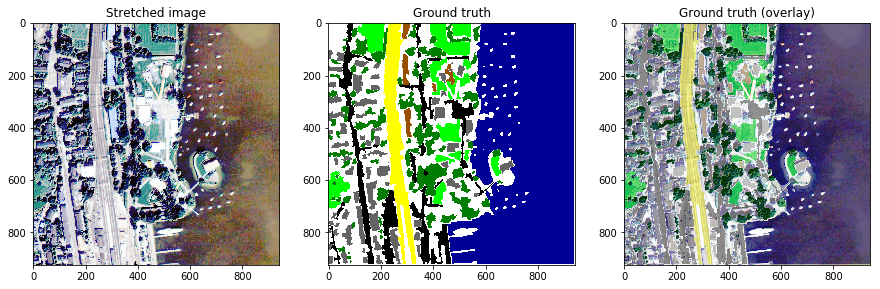

In [3]:
# Show image, its groundtruth image and overlay (to verify matching)
i = 2
alpha=.6
overlay = imgs_eq[i][:, :, :3] * alpha + gt[i] / 255 * (1-alpha)

# TODO don't stretch image

fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,7)
axes[0].imshow(imgs[i][..., :3], cmap='Greys_r')
axes[1].imshow(gt[i]/255, cmap='Greys_r')
axes[2].imshow(overlay, cmap='Greys_r')
axes[0].set_title("Stretched image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
plt.show()

## GT to labels
Next, we need to convert the ground truth (colors) to labels 

In [4]:
legend = OrderedDict((('Background', [255, 255, 255]),
                      ('Roads', [0, 0, 0]),
                      ('Buildings', [100, 100, 100]),
                      ('Trees', [0, 125, 0]),
                      ('Grass', [0, 255, 0]),
                      ('Bare Soil', [150, 80, 0]),
                      ('Water', [0, 0, 150]),
                      ('Railways', [255, 255, 0]),
                      ('Swimming Pools', [150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)
    
gt_maj_label = gt_color_to_label(gt, colors)

100%|██████████| 9/9 [00:05<00:00,  1.53it/s]


In [5]:
# Load Images
def flatten(l):
    return [item for sublist in l for item in sublist]


flat_labels = flatten(flatten(gt_maj_label))
print("Unique Labels in GT: ", np.unique(flat_labels))
print(np.shape(gt_maj_label))
gt = gt_maj_label

Unique Labels in GT:  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
(20,)


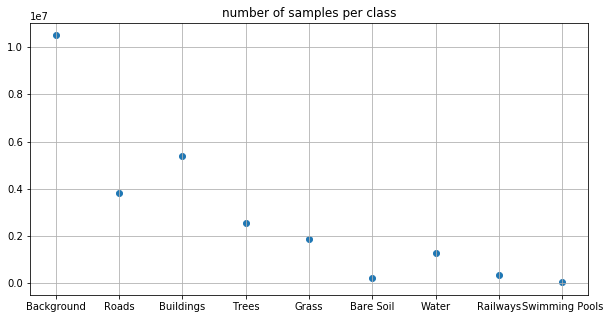

In [6]:
# print some statistics for the class distribution
unique, counts = np.unique(flat_labels, return_counts=True)
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(unique, counts)
ax.set_title('number of samples per class')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.grid()
plt.show()

## Get patches

In [7]:
# Get patches

patch_size = 64
stride_train = 64  # has to be <= patch_size
stride_test = 32  # has to be <= patch_size

# ids for training, validation and test sets (0-19)
ids_train = np.arange(0, 12)
ids_val = np.arange(12, 16)
ids_test = np.arange(16, 20)

# get training, test and validation sets
x_train = get_padded_patches(imgs[ids_train], patch_size=patch_size, stride=stride_train)
x_val = get_padded_patches(imgs[ids_val], patch_size=patch_size, stride=stride_train)
x_test = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=stride_test)
x_test_nostride = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=patch_size)

y_train = get_gt_patches(gt[ids_train], patch_size=patch_size, stride=stride_train)
y_val = get_gt_patches(gt[ids_val], patch_size=patch_size, stride=stride_train)
y_test = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=stride_test)
y_test_nostride = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=patch_size)

print(x_test.shape)
print(x_test_nostride.shape)
print(y_test_nostride.shape)

100%|██████████| 4/4 [00:00<00:00, 108.91it/s]

(3902, 64, 64, 4)
(964, 64, 64, 4)
(964, 64, 64)


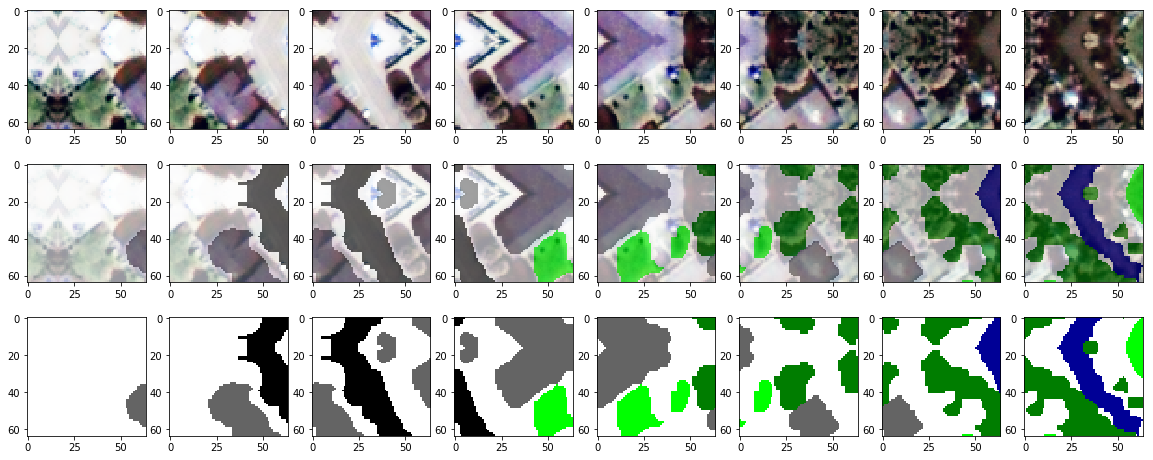

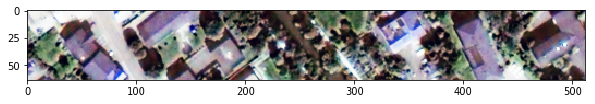

In [8]:
# visualize some patches 
imgs_row = 8
fig, axes = plt.subplots(3, imgs_row)
fig.set_size_inches(20, 8)
offset = 0
alpha = .6
for i in range(offset, offset + imgs_row):
    axes[0][i - offset].imshow(x_test[i][..., :3])  # images
    axes[1][i - offset].imshow(
        gt_label_to_color(y_test[i], colors) * alpha + x_test[i][..., :3] * (1 - alpha))  # ground truth (overlay)
    axes[2][i - offset].imshow(gt_label_to_color(y_test[i], colors))  # ground truth
    
# corresponding part of image
plt.figure(figsize=(10, 5))
plt.imshow(imgs[16][:64, :64 * 8, :3])

# Keras CNN

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

In [9]:
# create copies of original data
x_train_patches = x_train.copy()
x_val_patches = x_val.copy()
x_test_patches = x_test.copy()

y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

In [10]:
# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))

[0 1 2 3 4 5 6 7 8]
Class weights:
     Background: 0.000
          Roads: 0.757
      Buildings: 0.480
          Trees: 1.508
          Grass: 2.105
      Bare Soil: 7.000
          Water: 2.006
       Railways: 6.211
 Swimming Pools: 7.000


In [11]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train_patches)
x_val = np.asarray(x_val_patches)
x_test = np.asarray(x_test_patches)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

# remove class
class_to_remove = 3
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])
print(classes_to_keep)

names_keep = np.asarray(names)[classes_to_keep]
names_keep = names_keep.tolist()
print(names_keep)

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

## Train CNN

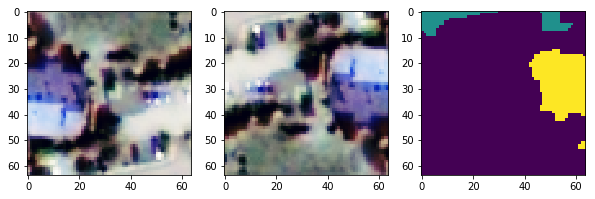

In [13]:
# data augmentation
img_idx = 14
im_patches_vis, gt_patches_vis = augment_images_and_gt(x_train_patches[img_idx], y_train_label[img_idx], rf_h=True,
                                                       rf_v=True, rot=True)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches((10, 5))
axes[0].imshow(x_train_patches[img_idx][..., :3])
axes[1].imshow(im_patches_vis[..., :3])
axes[2].imshow(gt_patches_vis)
plt.show()

In [14]:
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation=True):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   # callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count() * 2,
                        use_multiprocessing=True)

Instructions for updating:
Use the retry module or similar alternatives.


<Figure size 432x288 with 0 Axes>

In [45]:
# train or load model
# train the model
# model = get_unet(n_classes, x_train.shape[1:])
# model_train(model, data_augmentation=False)
model_unet = load_model(path + '/models_out/model_unet_64_flip_rot90_no_trees.h5',
                        custom_objects={'fn': ignore_background_class_accuracy(0)})

# save the model
# model_unet.save('models_out/model_unet_64_flip_rot90_no_water.h5')  # save model, weights


# Prediction

In [46]:
# Prediction

# get prediction
y_pred = model_unet.predict(x_train, batch_size=20, verbose=1)
y_pred_label = get_y_pred_labels(y_pred, class_to_remove=class_to_remove)

# Get accuracy as margin between highest and second highest class
y_pred_acc = get_accuracy_probas(y_pred)

3897/3897 [==============================] - 155s 40ms/step


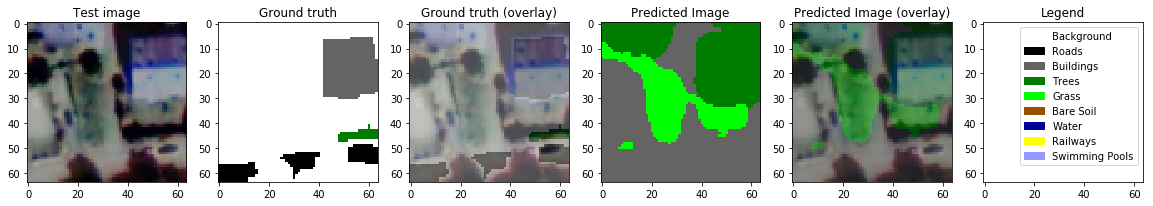

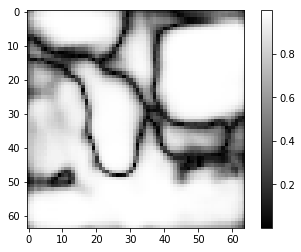

In [18]:
# plot prediction results
im_idx = 15
alpha = .3  # for overlay
fig, axes = plt.subplots(1, 6)
fig.set_size_inches(20, 20)
fig_im = x_train[im_idx][..., :3] * (1 - alpha)
fig_test = gt_label_to_color(y_train_label[im_idx], colors)
fig_pred = gt_label_to_color(y_pred_label[im_idx], colors)

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test * alpha + fig_im * (1 - alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred * alpha + fig_im * (1 - alpha))
axes[5].imshow(fig_im * 0 + 1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0], l[1]] for l in legend.items()]
handles = [Rectangle((0, 0), 1, 1, color=[v / 255 for v in c]) for n, c in legend_data]
labels = np.asarray([n for n, c in legend_data])
axes[5].legend(handles, labels)

# show certitude by network
fig = plt.figure()
plt.imshow(y_pred_acc[im_idx], cmap='gray')
plt.colorbar()

In [19]:
y_pred_im = [
    convert_patches_to_image(imgs, gt_label_to_color(y_pred_label, colors), img_idx=i, img_start=0, patch_size=64,
                             stride=64) for i in range(0, 3)]
y_test_im = [
    convert_patches_to_image(imgs, gt_label_to_color(y_train_label, colors), img_idx=i, img_start=0, patch_size=64,
                             stride=64) for i in range(0, 3)]

_, axes = plt.subplots(1, 2, figsize=(20, 15))
img_idx = 2
axes[0].imshow(y_pred_im[img_idx])  # prediction
axes[1].imshow(y_test_im[img_idx])  # gt stitched together
[axes[i].set_title(["prediction", "gt", "image"][i]) for i in range(2)]
plt.show()

# show also original image
plt.figure(figsize=(7, 7))
plt.imshow(imgs[img_idx][:, :, :3])
plt.show()

# Accuracy metrics

In [22]:
# Accuracy metrics
y_pred_labels_im = gt_color_to_label(np.multiply(deepcopy(y_pred_im), 255), colors)
y_test_labels_im = gt_color_to_label(np.multiply(deepcopy(y_test_im), 255), colors)

y_pred_flattened = [subitem for sublist in y_pred_labels_im.flatten() for item in sublist for subitem in item]
y_test_flattened = [subitem for sublist in y_test_labels_im.flatten() for item in sublist for subitem in item]

y_pred_flattened = np.asarray(y_pred_flattened).astype('int')
y_test_flattened = np.asarray(y_test_flattened).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

100%|██████████| 9/9 [00:00<00:00, 15.68it/s]


In [94]:
# Class accuracy, average accuracy
print(metrics.classification_report(
    y_pred_flattened[filter_items],
    y_test_flattened[filter_items],
    target_names=np.asarray(labels)[classes_to_keep],
    digits=3))

# Overall accuracy
OA = metrics.accuracy_score(y_pred_flattened[filter_items], y_test_flattened[filter_items])
print("Overall accuracy: %.3f" % OA)

                precision    recall  f1-score   support

     Buildings      0.034     0.134     0.055    115040
         Trees      0.147     0.067     0.092    480381
         Grass      0.964     0.739     0.837    469446
     Bare Soil      0.882     0.976     0.927     72456
         Water      0.990     0.997     0.994    281837
      Railways      0.518     0.938     0.667     31941
Swimming Pools      0.908     0.972     0.939      4736

   avg / total      0.612     0.537     0.561   1455837

Overall accuracy: 0.537


# Certainty using Density Forest

In [53]:
# image, layer indexes
layer_idx = -2
img_idx = 2

# get activations for training Density Forest
act_train = []
# for img_idx in ids_train:
for img_idx in tqdm(ids_train):  # TODO do with all images
    patches_begin = get_offset(imgs, 64, 64, 0, img_idx)
    patches_end = get_offset(imgs, 64, 64, 0, img_idx + 1)
    act_im = get_activations(model_unet, layer_idx, x_train[patches_begin:patches_end])
    act_train.append(act_im)

# get activations for testing Density Forest
act_test = []
for img_idx in tqdm(ids_test):
    patches_begin = get_offset(imgs, 64, 64, 16, img_idx)
    patches_end = get_offset(imgs, 64, 64, 16, img_idx + 1)
    act_im = get_activations(model_unet, layer_idx, x_test_nostride[patches_begin:patches_end])
    act_test.append(act_im)

100%|██████████| 4/4 [00:33<00:00,  8.45s/it]


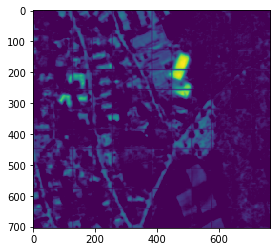

In [54]:
# remove the border effect by extracting overlapping regions of patches
img_start = 16
img_idx = 1
act_im = convert_patches_to_image(imgs, act_test[img_idx], img_idx=img_idx + img_start,
                                  img_start=img_idx + img_start, patch_size=64, stride=64)[np.newaxis]

# visualize an activation
plt.imshow(act_im[0][..., 3])
plt.show()

In [55]:
act_train_concat = np.concatenate(act_train, axis=0)
act_test_concat = np.concatenate(act_test, axis=0)

# get activations for unseen class
filter_unseen = (y_train_label != 0) & (y_train_label == class_to_remove)
act_unseen = act_train_concat[filter_unseen]

# retain only activation weights for which there is a ground truth
filter_seen = (y_train_label != 0) & (y_train_label != class_to_remove)
act_seen = act_train_concat[filter_seen]

# also get all as 1D
act_all_train = act_train_concat[filter_seen == filter_seen]
act_all_test = act_test_concat[y_test_nostride < np.infty]

Variance explained by first 5 components: 0.97


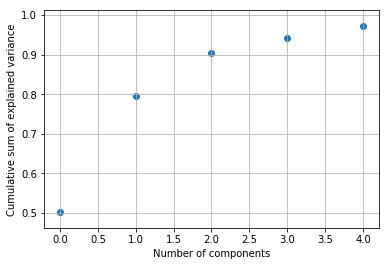

In [56]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=15)
pca.fit(act_seen)
n_components = np.alen(pca.explained_variance_ratio_[np.cumsum(pca.explained_variance_ratio_) < .95]) + 1
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_[:n_components])))
pca = decomposition.PCA(n_components=n_components)
pca.fit(act_seen)

X_seen = pca.transform(act_seen)
X_unseen = pca.transform(act_unseen)
X_all = pca.transform(act_all_test)

# validation label
y_seen_1D = y_train_label[filter_seen]

plt.cla()
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.show()

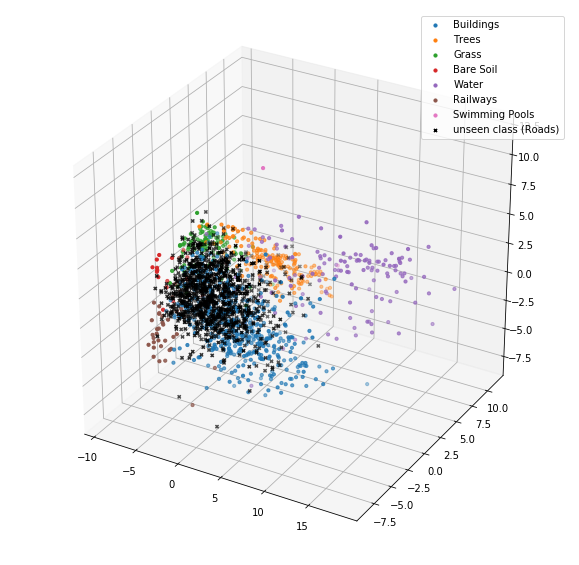

Variance explained by first 3 components: 0.90


In [57]:
# plot PCA points

# get data subset to show in figure
n_points = 1000
dataset_indices = np.arange(len(X_seen))

#  draw random samples with replacement
dataset_subset_indices = np.random.choice(dataset_indices, size=n_points, replace=True, )
dataset_subset = X_seen[dataset_subset_indices, :]

dataset_indices = np.arange(len(X_unseen))
dataset_subset_indices_unseen = np.random.choice(dataset_indices, size=n_points, replace=True, )


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=Axes3D.name)
for class_keep in classes_to_keep:
    plot_data = X_seen[dataset_subset_indices][y_seen_1D[dataset_subset_indices] == class_keep]
    plot_color = y_seen_1D[dataset_subset_indices][y_seen_1D[dataset_subset_indices] == class_keep]
    ax.scatter(plot_data[:, 0], plot_data[:, 1], zs=plot_data[:, 2], cmap=plt.get_cmap('rainbow'), s=10,
               depthshade=True)

ax.scatter(X_unseen[dataset_subset_indices_unseen, 0], X_unseen[dataset_subset_indices_unseen, 1],
           zs=X_unseen[dataset_subset_indices_unseen, 2], c='black', s=10, marker='x', depthshade=True)
names_legend = names_keep.copy()
names_legend.append('unseen class (' + names[class_to_remove] + ')')
ax.legend(names_legend)
# plt.savefig("../pca_components_3d_"+names[class_to_remove]+".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

## Train Density Forest

In [58]:
warnings.filterwarnings("ignore")
subset_data = 0.001
print("Number of points on which to train each tree: %i" % int(np.shape(X_seen)[0] * subset_data))
root_nodes_seen = density_forest_create(X_seen, n_classes, 20, subset_data, n_jobs=-1, verbose=10)

Number of points on which to train each tree: 7002


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    2.6s remaining:    4.0s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    5.0s remaining:    4.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    5.3s remaining:    2.3s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    6.6s remaining:    1.2s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    6.9s finished


In [59]:
# get probabilities for one image
n_jobs = 1  # for MacOS
patches_start = get_offset(imgs, 64, 64, 16, 18)
patches_end = get_offset(imgs, 64, 64, 16, 19)
probas = Parallel(n_jobs=n_jobs, verbose=1, max_nbytes=1e6)(  # try for multiprocessing
    delayed(density_forest_traverse_x)(
        X_all[patch_idx * (patch_size * patch_size):(patch_idx + 1) * (patch_size * patch_size), :],
        root_nodes_seen, thresh=.1)
    for patch_idx in range(patches_start, patches_end + 1))

100%|██████████| 4096/4096 [00:00<00:00, 11723.89it/s]


100%|██████████| 4096/4096 [00:00<00:00, 10888.95it/s]


100%|██████████| 4096/4096 [00:00<00:00, 11294.58it/s]


100%|██████████| 4096/4096 [00:00<00:00, 11572.05it/s]


100%|██████████| 4096/4096 [00:00<00:00, 11645.99it/s]
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed: 11.9min finished


In [60]:
n_patches = patches_end - patches_start
probas_seen_im = np.reshape(np.asarray(probas[:-1]), (n_patches, patch_size, patch_size))

# ad-hoc scaling of probabilities
# TODO replace by more rigorous standardization
# probas_seen_im = np.log(probas_seen_im)
# probas_seen_im = np.add(probas_seen_im, -np.nanmin(probas_seen_im[probas_seen_im!=-np.infty]))
# probas_seen_im = np.divide(probas_seen_im, np.nanmax(probas_seen_im[probas_seen_im!=np.infty]))

In [65]:
# get predictions without for y without stride to show side-by-side
y_pred_nostride = model_unet.predict(x_test_nostride, batch_size=20, verbose=1)
y_pred_nostride_label = get_y_pred_labels(y_pred_nostride, class_to_remove)

964/964 [==============================] - 33s 34ms/step


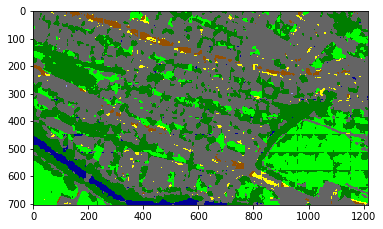

In [66]:
# get accuracy
y_pred_nostride_acc = get_accuracy_probas(y_pred_nostride)

y_pred_test_im = convert_patches_to_image(imgs, gt_label_to_color(y_pred_nostride_label, colors),
                                          img_idx=18, img_start=16, patch_size=64, stride=64)

y_pred_test_acc_im = convert_patches_to_image(imgs, y_pred_nostride_acc[..., np.newaxis],
                                              img_idx=18, img_start=16, patch_size=64, stride=64)

plt.imshow(y_pred_test_im)

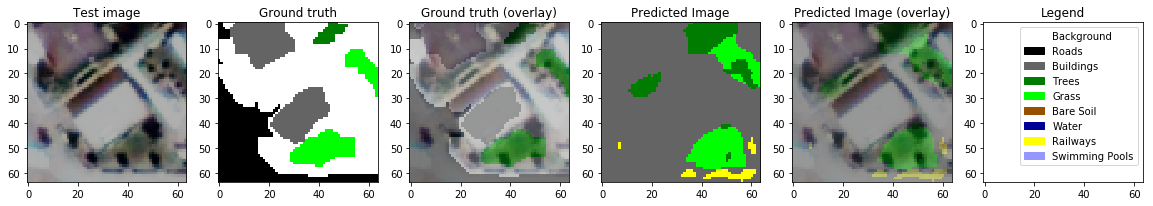

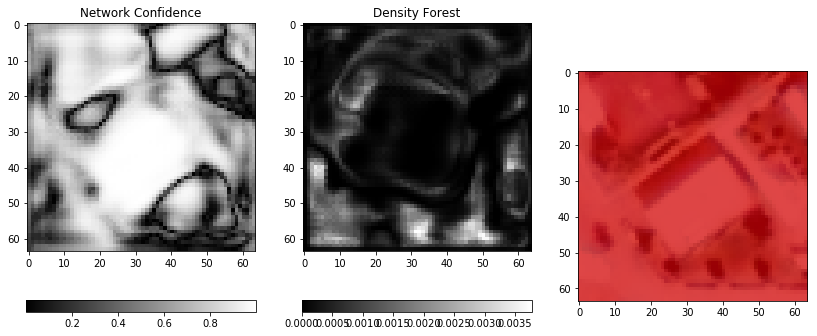

In [61]:
# plot prediction results with new uncertainty
#  %matplotlib inline
idx_im = get_offset(imgs, 64, 64, 16, im_idx)
idx_patch = 19
alpha = .3  # for overlay
fig, axes = plt.subplots(1, 6)
fig.set_size_inches(20, 20)
fig_im = x_test_nostride[idx_im + idx_patch][..., :3] * (1 - alpha)
fig_test = gt_label_to_color(y_test_nostride[idx_im + idx_patch], colors)
fig_pred = gt_label_to_color(y_pred_nostride_label[idx_im + idx_patch], colors)

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test * alpha + fig_im * (1 - alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred * alpha + fig_im * (1 - alpha))
axes[5].imshow(fig_im * 0 + 1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0], l[1]] for l in legend.items()]
handles = [Rectangle((0, 0), 1, 1, color=[v / 255 for v in c]) for n, c in legend_data]
labels = [n for n, c in legend_data]
axes[5].legend(handles, labels)

# show certitude by network
im_overlay = get_fig_overlay(fig_im, probas_seen_im[idx_patch], thresh=.93, opacity=.4)
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(14, 6)
f1 = axes[0].imshow(y_pred_nostride_acc[idx_im + idx_patch], cmap='gray')
fig.colorbar(f1, ax=axes[0], orientation='horizontal')
f2 = axes[1].imshow(probas_seen_im[idx_patch], cmap='gray')
fig.colorbar(f2, ax=axes[1], orientation='horizontal', spacing='proportional')
axes[0].set_title("Network Confidence")
axes[1].set_title("Density Forest")
axes[2].imshow(im_overlay)
plt.show()

In [62]:
# convert patches to image
img_idx = 18
im_cert_out = convert_patches_to_image(imgs, probas_seen_im[..., np.newaxis],
                                       img_idx=img_idx, patch_size=64,
                                       stride=64, img_start=img_idx)

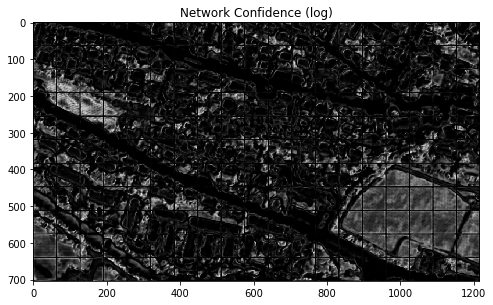

interactive(children=(FloatSlider(value=4.9999999999999996e-05, description='thresh', max=0.0001, min=1e-06, step=1e-06), Output()), _dom_classes=('widget-interact',))

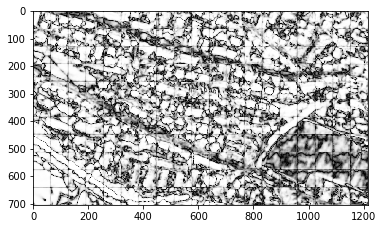

In [67]:
# show certitude by network
# image, overlay

fig = plt.figure(figsize=(8, 8))
plt.imshow(im_cert_out[..., 0], cmap='gray')
plt.title("Network Confidence (log)")
plt.show()

from ipywidgets import interact, FloatSlider
def fig_uncertainty(thresh):
    im_overlay = get_fig_overlay(imgs[img_idx][:im_cert_out.shape[0],:im_cert_out.shape[1],:3],im_cert_out[...,0],
                             thresh=thresh,opacity=.5)

    fig = plt.figure(figsize=(8,8))
    plt.imshow(im_overlay)
    plt.title("Low-Confidence Regions")
    plt.show()
    
interact(fig_uncertainty,thresh=(1e-6,1e-4,1e-6))

plt.imshow(y_pred_test_acc_im[...,0],cmap='gray')

In [68]:
av_cert = []
for label in np.arange(1, 9):
    av_cert.append(np.nanmean(im_cert_out[gt[img_idx][:im_cert_out.shape[0], :im_cert_out.shape[1]] == label]))
av_cert = np.asarray(av_cert)

print("Average certainty within class:")
for idx, w in enumerate(av_cert):
    print("%15s: %3.5f" % (names[idx + 1], w))

# ratio unseen class / seen classes
cert_unseen = av_cert[class_to_remove - 1]
cert_seen = np.nanmean(np.asarray(av_cert)[av_cert != cert_unseen])

print("Average certainty seen class:\t\t%.4f" % cert_unseen)
print("Average certainty unseen classes:\t%.4f" % cert_seen)
print("Ratio seen class / unseen classes:\t%.4f" % (cert_seen / cert_unseen))

Average certainty within class:
          Roads: 0.00015
      Buildings: 0.00022
          Trees: 0.00104
          Grass: 0.00120
      Bare Soil: nan
          Water: 0.00047
       Railways: nan
 Swimming Pools: nan
Average certainty seen class:		0.0002
Average certainty unseen classes:	0.0007
Ratio seen class / unseen classes:	4.8054
